In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

### Load yellow taxi data
[NY taxi dataset](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

In [32]:
# Read parquets and do some transformations
def read_data_frame(filename):
    df = pd.read_parquet(filename)
    df['duration'] = (df.tpep_dropoff_datetime - df.tpep_pickup_datetime)
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df['duration'] > 0) & (df['duration'] < 120) & (df['passenger_count'].notna())]

    categorical = ['PULocationID', 'DOLocationID']
    numerical = ['trip_distance']
    
    df[categorical] = df[categorical].astype(str)
    return df

In [33]:
# Prepare train and valdiation data

df_train = read_data_frame('../data/yellow_tripdata_2024-01.parquet')
df_val = read_data_frame('../data/yellow_tripdata_2024-02.parquet')

len(df_train), len(df_val)

(2820972, 2818415)

In [34]:
# Just describe dataset
df_train.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    2.820972e+06
mean     1.474504e+01
std      1.177543e+01
min      1.666667e-02
50%      1.150000e+01
95%      3.796667e+01
98%      5.070000e+01
99%      5.960000e+01
max      1.199667e+02
Name: duration, dtype: float64

/tmp/ipykernel_48375/1764197534.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train.duration)
/tmp/ipykernel_48375/1764197534.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_val.duration)


<AxesSubplot: xlabel='duration', ylabel='Density'>

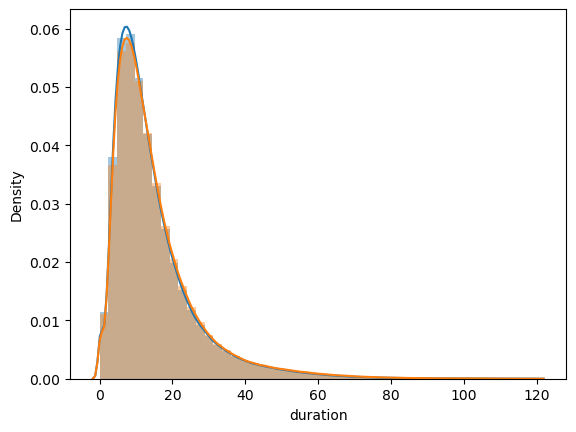

In [35]:
sns.distplot(df_train.duration)
sns.distplot(df_val.duration)

In [37]:
df_train.dtypes

VendorID                        float64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                     object
DOLocationID                     object
payment_type                    float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
Airport_fee                     float64
duration                        float64
dtype: object

In [41]:
# Hyperparam tunning
df_train['PU_DO'] = df_train['PULocationID'] + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + df_val['DOLocationID']

In [47]:
# *** Train model - Linear regression ***

categorical = ['PU_DO'] #['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

# Feature matrix for my model training
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

# Feature matrix for my model training
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

# Training part
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

# Prediction part
y_predict = lr.predict(X_val)

# Evaluation part
mean_squared_error(y_val, y_predict, squared=False)




6.851156051099668

In [49]:
# Save the model - we'll use this model for entire course
import pickle

with open('../models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

/tmp/ipykernel_48375/2396437901.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_predict, label='prediction')
/tmp/ipykernel_48375/2396437901.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


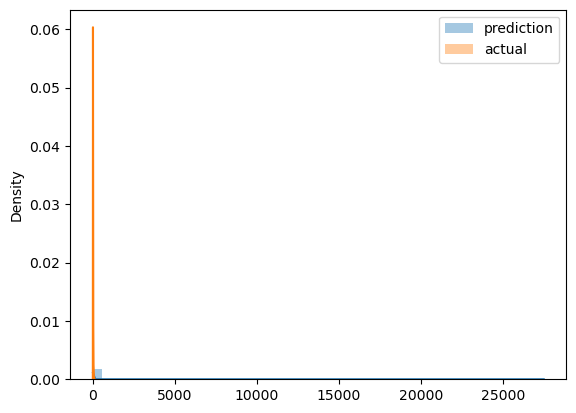

In [45]:
# Plot is somehow weird, maybe we need to do more data cleaning?
sns.distplot(y_predict, label='prediction')
sns.distplot(y_train, label='actual')
plt.legend()

## Try to use Laso reggresion

In [22]:
from sklearn.linear_model import Lasso

In [50]:
# *** Train model - Lasso regression ***

categorical = ['PU_DO'] #['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer() = DictVectorizer()

# Feature matrix for my model training
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

# Feature matrix for my model training
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

# Training part
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

lr_lasso = Lasso(alpha=0.1)
lr_lasso.fit(X_train, y_train)

# Prediction part
y_predict = lr_lasso.predict(X_val)

# Evaluation part
mean_squared_error(y_val, y_predict, squared=False)

32.80640530851559

## Homework

We'll use the same NYC taxi dataset, but instead of "Green Taxi Trip Records", we'll use "Yellow Taxi Trip Records".
Download the data for January and February 2023.

In [30]:
# Q1. Downloading the data
# Read the data for January. How many columns are there?

df_jan = pd.read_parquet('../data/yellow_tripdata_2023-01.parquet')
df_feb = pd.read_parquet('../data/yellow_tripdata_2023-02.parquet')

print("Number of columns (january DF): ", len(df_jan.columns))

Number of columns (january DF):  19


In [31]:
# Q2. Computing duration
# Now let's compute the duration variable. It should contain the duration of a ride in minutes. 
# What's the standard deviation of the trips duration in January?
def add_duration(df):
    df['duration'] = (df.tpep_dropoff_datetime - df.tpep_pickup_datetime)
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

add_duration(df_jan)
add_duration(df_feb)

In [32]:
print('Standard deviation (january DF):', round(df_jan['duration'].std(), 2))

Standard deviation (january DF): 42.59


In [33]:
# Q3. Dropping outliers
# Next, we need to check the distribution of the duration variable. There are some outliers. Let's remove them and keep
# only the records where the duration was between 1 and 60 minutes (inclusive). What fraction of the records left after 
# you dropped the outliers?
def filter_dataframe(df):
    filtered = df[(df_jan['duration'] > 1) & (df['duration'] < 60)]
    return filtered

df_jan_filtered = filter_dataframe(df_jan)
df_feb_filtered = filter_dataframe(df_feb)

df_jan_len = len(df_jan.index)
df_jan_filtered_len = len(df_jan_filtered.index)

fraction_left = (df_jan_filtered_len / df_jan_len) * 100
print(f'Fraction of the record left (january DF): {round(fraction_left, 0)}%')

/tmp/ipykernel_70920/3416407160.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered = df[(df_jan['duration'] > 1) & (df['duration'] < 60)]


Fraction of the record left (january DF): 98.0%


In [40]:
# 04. One hot encoding
# Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.
# - Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)
# - Fit a dictionary vectorizer
# - Get a feature matrix from it
# What's the dimensionality of this matrix (number of columns)?
def x_data(df):
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    train_dicts = df[categorical].to_dict(orient='records')

    dv = DictVectorizer()
    return dv.fit_transform(train_dicts)

X_train = x_data(df_jan_filtered)
X_val = x_data(df_feb_filtered)

print('Dimensionality of the train matrix (january DF): ', X_train.ndim)

/tmp/ipykernel_70920/2889782080.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)
/tmp/ipykernel_70920/2889782080.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


Dimensionality of the train matrix (january DF):  2


In [46]:
# 05. Training model
# Now let's use the feature matrix from the previous step to train a model.
# - Train a plain linear regression model with default parameters
# - Calculate the RMSE of the model on the training data
# What's the RMSE on train?
def train_and_predict(lr, X_train, y_train):
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    return lr.predict(X_train)

    
y_train = df_jan_filtered['duration'].values
y_train_predict = train_and_predict(lr, X_train, y_train)

y_val = df_feb_filtered['duration'].values
y_val_predict =  train_and_predict(lr, X_val, y_val)

In [47]:
rmse_train = mean_squared_error(y_train, y_train_predict, squared=False)
rmse_val = mean_squared_error(y_val, y_val_predict, squared=False)
print(f'RMSE train value: {round(rmse_train, 2)}, RMSE val value: {round(rmse_val, 2)}')

RMSE train value: 7.65, RMSE val value: 8.06


/tmp/ipykernel_70920/2396437901.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_predict, label='prediction')
/tmp/ipykernel_70920/2396437901.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


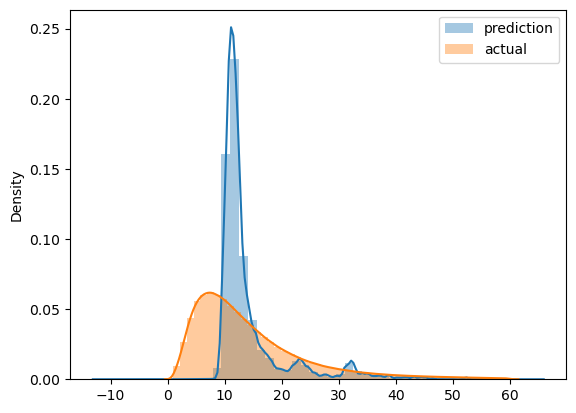

In [27]:
sns.distplot(y_predict, label='prediction')
sns.distplot(y_train, label='actual')
plt.legend()